<a href="https://colab.research.google.com/github/visoutre/ai-notebooks/blob/main/Stable_Diffusion_Batch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Stable Diffusion Batch by [visoutre](https://www.reddit.com/user/visoutre)

Location for updates: [Stable Diffusion Batch.ipynb](https://colab.research.google.com/github/visoutre/ai-notebooks/blob/main/Stable_Diffusion_Batch.ipynb)

<b> v 2.2.2, last updated 9/02/22 </b>
<br>
- Expand to view info...


<u>**Credits:**</u>
- the setup work was done by [FutureArt](https://twitter.com/future__art) and [Pharmapsychotic](https://twitter.com/pharmapsychotic), credit goes to them for getting me started
- I added the bulk of features useful to concept art and img2img
- I used some public code to implement openCV facial recognition for face detailing

<u>**Terms of Use:**</u>
- This code is free to use however you want. You may use it, modify it and do anything with it without crediting me for the code (although it would be nice to get give me a mention if you use this code)
- Any images you create using this code fall under the terms set by [huggingface.co](https://huggingface.co/CompVis/stable-diffusion) , [Stability.Ai](https://stability.ai/) as well as Google Colab terms. You must use this technology ethically. I am not responsible for anything you create, nor do I own any of your creations
- I recommend only using input images you own the copywrite to, otherwise you may be liable to copywrite infringement 
- Any text prompts I share in code or elsewhere are free for you to use however you want, unrestricted and without credit to me. I believe prompts should be public and shared freely
- You may use any of your creations privately and commercially without credit
- Any images I create with this code are owned by me and you may not use any of my examples for commercial use, especially my original art. Respect me for sharing this code freely

<br> 

---

<u>**Key Features Include:**</u>
 - process a single image or multiple images, single prompts or multiple prompts
 - randomizing starting keyword in the prompts for variations on a theme
 - processing sequential guidance scales and image strengths on a seed for data
 - randomizing guidance scales and image strengths for exploration
 - processing a list of prompts with a corresponding image for consistency
 - processing a list of prompts with a random image for creativity
 - save prompt templates which can be quickly loaded
 - cycle through multiple prompt templates with multiple input images/prompts
 - the prompt cycling feature are like having your own art design team who can create different styles or follow a style!

<u>**Upcoming Plans (todo list):**</u>
  - port locally to use with an RTX / better GUI (long term)
  - template for body parts to make compositing crops quicker and batched (often I upres face, hands, armor/clothes x2)


<br>

---
<u>**Changelog:**</u>

v 2.2.2, last updated 9/02/22:
- cleaned up the documentation, cleaned up the sections and reordered some fields
- added aspect ratio templates

v 1 to 2:  updated between 8/27/22 and 9/01/22:
- experimented with core features to assist with concept art & design
- added interpolation, multiple input images, prompt templates, etc
- began exploring advanced features with openCV such as using facial recognition to clean up faces automatically

v 1.0.0, last updated 8/27/22:
- began the Stable Diffusion journey with FutureArt and Pharmapsychotic's collab file as a starting point
- my initial intention was to take their version that had multiple prompts and allow those prompts to correspond with their own unique input images

<br>

---

<u>**How to download the Stable Diffusion model:**</u>

- Visit https://huggingface.co/CompVis/stable-diffusion-v-1-4-original and agree to the terms and conditions.
- Click the **Files and versions** tab
- Click **stable-diffusion-v-1-4-original**
- Click the **download** link where it says *This file is stored with Git LFS . It is too big to display, but you can still download it.*
- If you have [Google Drive for desktop](https://www.google.com/drive/download/) (highly recommended), you can save it directly to your **AI/models** directory.
  - Otherwise, download it and re-upload it to your [Google Drive](https://drive.google.com) in the **AI/models** directory. (This is risky, as the upload may time out.)

# 1. <u> Setup (Run All) </u>
- simply run the arrow here to set everything up, no need to open this section or mess with settings
- make sure you have the Stable Diffusion model saved to your drive in AI/models/sd-v1-4.ckpt

In [ ]:
#@title Check GPU
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-eb9a2b1f-982f-d2ce-cef7-d0c9c593f907)


In [ ]:
#@title Mount Google Drive and Prepare Folders
from google.colab import drive
drive.mount('/content/gdrive')
outputs_path = "/content/gdrive/MyDrive/AI/StableDiffusionBatch"
!mkdir -p $outputs_path
!mkdir -p "init_image"
print(f"Outputs will be saved to {outputs_path}")

Mounted at /content/gdrive
Outputs will be saved to /content/gdrive/MyDrive/AI/StableDiffusionBatch


In [ ]:
#@title Installation
!pip install pytorch-lightning torch-fidelity
!pip install numpy omegaconf einops kornia pytorch-lightning
!pip install albumentations transformers
!pip install ftfy jsonmerge resize-right torchdiffeq tqdm

!git clone https://github.com/CompVis/stable-diffusion
%cd stable-diffusion/
!git clone https://github.com/CompVis/taming-transformers
!git clone https://github.com/openai/CLIP.git
!git clone https://github.com/crowsonkb/k-diffusion.git

import sys
sys.path.append(".")
sys.path.append("./CLIP")
sys.path.append('./taming-transformers')
sys.path.append('./k-diffusion')

!echo '' > ./k-diffusion/k_diffusion/__init__.py

# Installation Setup for Facial Recognition when using Crop Upres Feature:
!pip install opencv-python
import cv2
!pip install numpy
!pip install matplotlib

In [ ]:
#@markdown You need to get the model weights yourself and put on Google Drive or this Colab instance
checkpoint_model_file = "/content/gdrive/MyDrive/AI/models/sd-v1-4.ckpt" #@param {type:"string"}

In [ ]:
#@title Define helper functions

import argparse, gc, json, os, random, sys, time, glob, requests
import torch
import torch.nn as nn
import numpy as np
import PIL
from contextlib import contextmanager, nullcontext
from einops import rearrange, repeat
from IPython.display import display, clear_output
from itertools import islice
from omegaconf import OmegaConf
from PIL import Image
from pytorch_lightning import seed_everything
from torch.cuda.amp import autocast
from ldm.util import instantiate_from_config
from ldm.models.diffusion.ddim import DDIMSampler
from ldm.models.diffusion.plms import PLMSSampler

from k_diffusion.sampling import sample_lms
from k_diffusion.external import CompVisDenoiser


def chunk(it, size):
    it = iter(it)
    return iter(lambda: tuple(islice(it, size)), ())

def load_model_from_config(config, ckpt, verbose=False):
    print(f"Loading model from {ckpt}")
    pl_sd = torch.load(ckpt, map_location="cpu")
    if "global_step" in pl_sd:
        print(f"Global Step: {pl_sd['global_step']}")
    sd = pl_sd["state_dict"]
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    if len(m) > 0 and verbose:
        print("missing keys:")
        print(m)
    if len(u) > 0 and verbose:
        print("unexpected keys:")
        print(u)

    model.cuda()
    model.eval()
    return model

class CFGDenoiser(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.inner_model = model

    def forward(self, x, sigma, uncond, cond, cond_scale):
        x_in = torch.cat([x] * 2)
        sigma_in = torch.cat([sigma] * 2)
        cond_in = torch.cat([uncond, cond])
        uncond, cond = self.inner_model(x_in, sigma_in, cond=cond_in).chunk(2)
        return uncond + (cond - uncond) * cond_scale

class config():
    def __init__(self):
        self.ckpt = checkpoint_model_file
        self.config = 'configs/stable-diffusion/v1-inference.yaml'
        self.ddim_eta = 0.0
        self.ddim_steps = 100
        self.fixed_code = True
        self.init_img = None
        self.n_iter = 1
        self.n_samples = 1
        self.outdir = ""
        self.precision = 'full' # 'autocast'
        self.prompt = ""
        self.sampler = 'klms'
        self.scale = 7.5
        self.seed = 42
        self.strength = 0.75 # strength for noising/unnoising. 1.0 corresponds to full destruction of information in init image
        self.H = 512
        self.W = 512
        self.C = 4
        self.f = 8
      
def load_img(path, w, h):
    if path.startswith('http://') or path.startswith('https://'):
        image = Image.open(requests.get(path, stream=True).raw).convert('RGB')
    else:
        if os.path.isdir(path):
            files = [file for file in os.listdir(path) if file.endswith('.png') or file .endswith('.jpg')]
            path = os.path.join(path, random.choice(files))
            print(f"Chose random init image {path}")
        image = Image.open(path).convert('RGB')
    image = image.resize((w, h), Image.LANCZOS)
    w, h = image.size
    w, h = map(lambda x: x - x % 32, (w, h))  # resize to integer multiple of 32
    image = image.resize((w, h), resample=PIL.Image.LANCZOS)
    image = np.array(image).astype(np.float32) / 255.0
    image = image[None].transpose(0, 3, 1, 2)
    image = torch.from_numpy(image)
    return 2.*image - 1.

opt = config()
config = OmegaConf.load(f"{opt.config}")
model = load_model_from_config(config, f"{opt.ckpt}")
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = model.to(device)
batch_idx = 0
sample_idx = 0

def generate(opt):
    global sample_idx
    seed_everything(opt.seed)
    os.makedirs(opt.outdir, exist_ok=True)

    if opt.sampler == 'plms':
        sampler = PLMSSampler(model)
    else:
        sampler = DDIMSampler(model)

    model_wrap = CompVisDenoiser(model)       
    batch_size = opt.n_samples
    prompt = opt.prompt
    assert prompt is not None
    data = [batch_size * [prompt]]
    init_latent = None

    if opt.init_img != None and opt.init_img != '':
        init_image = load_img(opt.init_img, opt.W, opt.H).to(device)
        init_image = repeat(init_image, '1 ... -> b ...', b=batch_size)
        init_latent = model.get_first_stage_encoding(model.encode_first_stage(init_image))  # move to latent space

    sampler.make_schedule(ddim_num_steps=opt.ddim_steps, ddim_eta=opt.ddim_eta, verbose=False)

    t_enc = int(opt.strength * opt.ddim_steps)

    start_code = None
    if opt.fixed_code and init_latent == None:
        start_code = torch.randn([opt.n_samples, opt.C, opt.H // opt.f, opt.W // opt.f], device=device)

    precision_scope = autocast if opt.precision == "autocast" else nullcontext

    images = []
    with torch.no_grad():
        with precision_scope("cuda"):
            with model.ema_scope():
                for n in range(opt.n_iter):
                    for prompts in data:
                        uc = None
                        if opt.scale != 1.0:
                            uc = model.get_learned_conditioning(batch_size * [""])
                        if isinstance(prompts, tuple):
                            prompts = list(prompts)
                        c = model.get_learned_conditioning(prompts)

                        if init_latent != None:
                            z_enc = sampler.stochastic_encode(init_latent, torch.tensor([t_enc]*batch_size).to(device))
                            samples = sampler.decode(z_enc, c, t_enc, unconditional_guidance_scale=opt.scale,
                                                    unconditional_conditioning=uc,)
                        else:

                            if opt.sampler == 'klms':
                                print("Using KLMS sampling")
                                shape = [opt.C, opt.H // opt.f, opt.W // opt.f]
                                sigmas = model_wrap.get_sigmas(opt.ddim_steps)
                                model_wrap_cfg = CFGDenoiser(model_wrap)
                                x = torch.randn([opt.n_samples, *shape], device=device) * sigmas[0]
                                extra_args = {'cond': c, 'uncond': uc, 'cond_scale': opt.scale}
                                samples = sample_lms(model_wrap_cfg, x, sigmas, extra_args=extra_args, disable=False)
                            else:
                                shape = [opt.C, opt.H // opt.f, opt.W // opt.f]
                                samples, _ = sampler.sample(S=opt.ddim_steps,
                                                                conditioning=c,
                                                                batch_size=opt.n_samples,
                                                                shape=shape,
                                                                verbose=False,
                                                                unconditional_guidance_scale=opt.scale,
                                                                unconditional_conditioning=uc,
                                                                eta=opt.ddim_eta,
                                                                x_T=start_code)

                        x_samples = model.decode_first_stage(samples)
                        x_samples = torch.clamp((x_samples + 1.0) / 2.0, min=0.0, max=1.0)

                        for x_sample in x_samples:
                            x_sample = 255. * rearrange(x_sample.cpu().numpy(), 'c h w -> h w c')
                            images.append(Image.fromarray(x_sample.astype(np.uint8)))
                            filepath = os.path.join(opt.outdir, f"{batch_name}({batch_idx:03})_{sample_idx:04} {opt.seed}.png")#####
                            print(f"Saving to {filepath}")
                            Image.fromarray(x_sample.astype(np.uint8)).save(filepath)
                            sample_idx += 1
    return images


Loading model from /content/gdrive/MyDrive/AI/models/sd-v1-4.ckpt
Global Step: 470000
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels


Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.19.mlp.fc1.bias', 'vision_model.encoder.layers.16.layer_norm1.bias', 'vision_model.encoder.layers.14.self_attn.k_proj.weight', 'vision_model.encoder.layers.15.self_attn.v_proj.weight', 'vision_model.encoder.layers.23.self_attn.q_proj.weight', 'vision_model.encoder.layers.2.self_attn.k_proj.weight', 'vision_model.encoder.layers.0.self_attn.out_proj.weight', 'vision_model.encoder.layers.0.mlp.fc2.weight', 'vision_model.encoder.layers.22.self_attn.v_proj.bias', 'vision_model.encoder.layers.18.self_attn.k_proj.bias', 'vision_model.encoder.layers.6.layer_norm2.weight', 'vision_model.encoder.layers.9.layer_norm2.weight', 'vision_model.encoder.layers.16.self_attn.v_proj.weight', 'vision_model.encoder.layers.21.self_attn.v_proj.bias', 'vision_model.encoder.layers.8.self_attn.k_proj.weight', 'vision_model.encoder.layers.11.layer_norm2.weight', 'visio

# <u> Information on How to Use</u> *(DON'T RUN; this is Purely Informative / Documentation)*
- this section only contains reminders and tips on usage. Section 2. Batch Prompting is the working code

In [ ]:
'''
#@title Prompting:
#@markdown `NOTE: The settings in this informative cell are the code defaults for the most basic use.` 
<br>
#@markdown `If you have issues or want to revert, set the fields in the code cell (inside Section 2. Batch Prompting) to these values`
<br>
#@markdown `It's also best to make sure all the optional fields are set to 0, checked off, or none unless you intend to use the feature`


##1---------------------------------------------------------------------------------------------
#@markdown ---
#@markdown > <u>**Section 1): Saving/Folder Settings** *(required):* <br></u>
##@markdown Shared Prompt Ending:
#@markdown 1b) **`outputFolder`**
#@markdown - folder name where this session will store the images<br>
#@markdown - This folder will exist (by default) under content/gdrive/MyDrive/AI/StableDiffusionBatch/`
<br>
#@markdown 1b) **`saveSeperatePromptsToSubfolders`**
#@markdown - True = save each prompt in a seperate folder, first 3 strings in prompt = folder name
#@markdown - False = save all prompts results in the same outputFolder (defined above in 1a)<br>
<br>
1a) outputFolder = "upres_portraits4" #@param {type:"string"}
1b) saveSeperatePromptsToSubfolders = False#@param{type:"boolean"}
#@markdown ---


##2---------------------------------------------------------------------------------------------
#@markdown > <u>**Section 2): Prompt Template** *(optional):*</u>
<br>
#@markdown `Note: set to 'none/custom' if you rather type your prompt details than use a preset. This is for convenience`
<br>
#@markdown `Note: adding a new preset requires these 3 steps: `
#@markdown - 1) adding a new line to the promptTemplateDict dictionary (number it correctly too)
#@markdown - 2) adding this prompt as a new drop down option in promptTemplate (in the cell code, line 31~)
#@markdown - 3) adding the dropdown text as an additional elif statement in the code (look at the pattern and repeat)
<br>
#@markdown 2a) **`promptTemplate`**
#@markdown - the core prompt templates. You can select a template to reuse the same starting word + ending strings used in the prompt
#@markdown - use these to save the inconvenience of copy/pasting the same text over and over again. focus on writing the subject instead
#@markdown - *Python structure -* **key: ['templateStartWord', 'prompt details']** | example - 10: ['tattoo design of', 'inking, drawing, detailed, art by artist']

# in addition to writing the prompts here, you need to add them to the promptTemplate #@param in the main code, otherwise it won't show up to select

promptTemplateDict = {
0: ['', 'none'],
<br>
#@markdown 2b) **`emotiveTemplate`**
#@markdown - similar to promptTemplate, these strings only go at the end of the prompt to give a consistent influence to results
#@markdown - example of use: if you want variants of all your character portraits to be zombies, or to be happy, use this feature
#@markdown - *disclaimer:* may not work as intended all the time (especially with long prompts; this text gets truncated
<br>
#@markdown 2c) **`randomEnd`**
#@markdown - text that goes at the end of all prompts. use comma to split the text and randomize between comma
<br>

2a) promptTemplate = 'none/custom' #@param ["none/custom","character - female adult", "character - male adult", "environment - scifi", "environment - fantasy", "vehicle - sketch", "vehicle - render", "style - anime keyframe (use high guidance scale of 15+)", "style - comic art inks", "style - blackwork / heavily inked tattoos", "fun - action figure character", "fun - stickers", "fun - marble statue"]
2b) emotiveTemplate = 'none' #@param ["none", "happy", "angry", "sad", "zombie", "psychedelic", "sketchy drawing style"]
2c) randomEnd = "" #@param {type:"string"}
#@markdown ---



##3---------------------------------------------------------------------------------------------
#@markdown > <u>**Section 3): Prompt Details** *(optional - toggle on/off):* <br></u>
<br>
#@markdown `Note: Your prompt must be 77 tokens or less. Any longer and the extra text gets truncated` <br>
#<br>
#@markdown There's many options for splitting up the prompts:<br>
#<br>
#@markdown - 3a): **`useThese3PromptFields`:** includes art styles or artist names *(ex. art by  alphonse mucha)*<br>
#<br>
#@markdown  - 3b): **`randomStart`:** an initial word that is randomly selected to go at the start of the prompt<br>
#@markdown    - I recommend 2 ways to use randomStart:<br>
#@markdown  - 1) use a list of multiple emotions or elements *(ex. icy, firey, rainy)*<br>
#@markdown  - 2) leave only a single option if you have a consistent theme *(ex. 'female' or 'male')*<br>
#<br>
#@markdown - 3c):**`midDetails`:** includes keywords to create higher detailed results *(ex. highly detailed, rendered in octane)*<br>
#<br>
#@markdown - 3d): **`endingStyle`:** includes art styles or artist names *(ex. art by  alphonse mucha)*<br>
#<br>
#@markdown `NOTE: you don't have to split your prompts with these seperate fields. You can simply write the whole prompt in midDetails or in the batch prompt list too`<br>
#<br>
#<br>
#@markdown  Example of How Prompts Combine: 
#@markdown - [randomStart] + **[batchPrompt]** + [midDetails] + [endingStyle] + [randomEnd]<br>
#@markdown  - `Example 1:` [pearlescent] **[jellyfish in space],** [digital art, concept art...], [by Alex Ross...]<br>
#@markdown  - `Example 2:` [pearlescent] **[Lamborghini],** [digital art, concept art...], [by Alex Ross...]<br>
#@markdown  - `Example 3:` [glowing] **[frogs on lily pads],** [digital art, concept art...], [by Alex Ross...]<br>
#@markdown  - `Example 4:` [sparkling] **[shells on a beach],** [digital art, concept art...], [by Alex Ross...]<br>
#@markdown - Notice in the examples the first word is random and the midDetail + endingStyle words are consistent
#@markdown - The batch prompts are set up in a list a seperate cell under the variable **promptsA**<br>
#<br>

3a) useThese3PromptFields = True#@param{type:"boolean"}
3b) randomStart = "female" #@param {type:"string"}
3c) midDetails = "digital art, concept art, smooth, sharp focus, high definition, rendered in Octane" #@param {type:"string"}
3d) endingStyle = "illustration, art by artgerm and greg rutkowski and alphonse mucha" #@param {type:"string"}
#@markdown ---


##4---------------------------------------------------------------------------------------------
#@markdown > <u>**Section 4): Basic Settings** *(required - all modes):* </u><br>
<br>
#@markdown 4a) **`width and height`:**
#@markdown - image dimensions. range of 512-768 is best for portrait. Max is 704 x 704 depending on the GPU <br>
#<br>
#@markdown 4b) **`aspectRatio`:**
#@markdown - Presets for standard image ratios to quickly choose between. Print as well as Film Ratio standards<br>
#<br>
#@markdown 4c) **`guidance_scale`:**
#@markdown - strength of text prompt. 15 is good, 20 can have greater realism. 7 was beta default. Experiment<br>

#<br>
#@markdown 4d) **`steps`:**
#@markdown - number of diffusion steps. more takes longer, but has better detail. test with 5-20 and use 50-80. rarely exceed 100 (costly and insignificant)<br>
#<br>
#@markdown 4e) **`number_of_repeats`:**
#@markdown - how many rounds of iterating through the prompt list. the prompts always run from first to last of each before repeating<br>
#<br>
#@markdown 4f) **`sampler`:**
#@markdown - it seems klms is default, but sometime of my results worked better with ddim, especially portraits<br>
#<br>
#@markdown 4g) **`seed`:**
#@markdown - set -1 to generate by random, otherwise input # seed to regenerate. Make use of randomStart/End with seed for fun variations, or use it for the sequence (same seed = consistent)<br>
#<br>
#@markdown 4h) **`first_prompt_only`:**
#@markdown - will only run on the first prompt in the prompts list<br>
#@markdown - good if you want to test on a single image without requiring the deletion of the list<br>
#<br>
4a) width = 640 #@param {type:"integer"}
4a) height = 640 #@param {type:"integer"}
4b) aspectRatio = 'custom' #@param ["custom","1:1  (square)","4:3  (standard)","16:9 (widescreen)","21:9 (ultrawide)","4:5  (instagram)","8x11 (paper standard)","2:3  (poster standard)"]
width_height = [width, height] # param{type: 'raw'}
4c) guidance_scale = 15 #@param {type:"slider", min:0, max:40, step:0.5}
4d) steps = 50 #@param {type:"integer"}
samples_per_batch = 1 # not exposed, you can do 2 or more based on GPU ram, if get CUDA out of memory need to restart runtime
number_of_images = 1 #param {type:"integer"}
4e) number_of_repeats = 3 #@param {type:"integer"}
4f) sampler = 'ddim' #@param ["klms","plms", "ddim"]
ddim_eta = 0.75 # param {type:"number"}
4g) seed = -1 # @param {type:"integer"}
4h) firstPromptOnly = False#@param{type:"boolean"}
#@markdown ---


##5---------------------------------------------------------------------------------------------
#@markdown > <u>**Section 5): Init Image (img2img)** *(optional):*</u><br> 
<br>
#@markdown `Note: you must upload the image(s) to the init_image folder on the left Files menu under the / content/init_image/ folder, or change the defaultInitPath`<br>
#<br>
#@markdown 5a) **`randomizeImageFromFolder:`**
#@markdown  - leave unchecked (False) to go through the list of images that are lined up with the prompt
#@markdown  - set to True to pull a random image from the **defaultInitPath** to go with your prompts`<br>
#<br>
#@markdown - some notes on randomization:<br>
#@markdown  - if you leave randomization off, make sure your count of images matches the number of prompts in both lists 10 prompts = 10 images<br>
#@markdown  - if you randomize the init_images, then you don't have to have the matching # of prompts to image. You could have 3 images in the folder and 100 prompts<br>
#<br>
#@markdown 5b) **`defaultInitPath:`**
#@markdown - where the init_images need to be saved to load. /content/ is fine most of the time
#@markdown - a custom drive path is great if you want to save collections on your drive to use randomly across different promps
<br>
#@markdown 5c) **`initial_image`:**
#@markdown - if you want to work with a single image without setting up the list array, then you can enter the image name/extension here<br>
#@markdown - otherwise you can leave this field blank<br>
#<br>
#@markdown 5d) **`init_strength`:** *IMPORTANT* I use this option the most *(since I use img2img the most)*<br>
#@markdown - Adjust the intensity of how much the input image influences the result<br>
#@markdown - 0 means no input image is used. range 0.1 - 0.3 follows loose for creativity. 0.45 - 0.7 follows image closer for consistency
#@markdown - The strength goes in increments of 0.1, however you will find that 0.05 is also a valid and different result in between 0 and 0.1!
<br>
5a) randomizeImageFromFolder = False#@param{type:"boolean"}
5b) defaultInitPath = "/content/init_image/" #@param {type:"string"}
5c) initial_image = "" #@param {type:"string"}
init_image_or_folder = "/content/init_image/" + initial_image
5d) init_strength = 0 #@param {type:"number"}
#@markdown ---



##6---------------------------------------------------------------------------------------------
#@markdown > <u>**Section 6): Sequence Settings - Cycles** *(Through Ranges - optional):* <br></u>
<br>
#@markdown -  `Note 1: check both init_strength_0_to_1 and cfg_scale_7_to_20 to True to generate a grid of possibilities. 80 generations`<br>
#@markdown -  `Note 2: Can iterate on a seed through the scales to see how the values affect results, or randomize:`

#@markdown 6a) **`cycleThroughPromptList`:**
#@markdown - activate to cycle through the prompt list templates to generate **variations** on the same prompts
#<br>
#@markdown 6b) **`templatesToCycle`:**
#@markdown - when cycleThroughPromptList=True, these are the keys of the Prompt Templates to cycle through
#@markdown - example: 1,2 means a female and a male in a digital painting style is created for each prompt (granted you have default prompt templates)
#@markdown - the key numbers can be found labeled in the promptTemplateDict variable
#<br>
#@markdown 6c) **`init_strength_0_to_1`:**
#@markdown - Goes through image strength setting 0 - 1 to see its effects. runs only on 1st prompt
#<br>
#@markdown 6d) **`cfg_scale_7_to_20`:**
#@markdown -  Goes through guidance_scale setting 7 - 20 to see its effects. runs only on 1st prompt
#<br>
#@markdown 6e) **`init_strength_random`:**
#@markdown - randomly picks an image strength value from 0.1 to 0.7<br>
#<br>
#@markdown 6f) **`cfg_scale_random`:**
#@markdown - randomly picks an guidance_scale value from 7 to 20<br>
#<br>
6a) cycleThroughPromptList = False#@param{type:"boolean"}
6b) templatesToCycle = "1,2" #@param {type:"string"}
# these options would run 14 times:
6c) init_strength_0_to_1 = False#@param{type:"boolean"}
6d) cfg_scale_7_to_20 = False#@param{type:"boolean"}
6e) init_strength_random = False#@param{type:"boolean"}
6f) cfg_scale_random = False#@param{type:"boolean"}
save_settings_file = False#param{type:"boolean"}
#@markdown ---


##7---------------------------------------------------------------------------------------------
#@markdown > <u>**Section 7): Sequence Settings with Images** *(optional interpolation):* <br></u>
<br>
#@markdown 7a) **`generatedImageCycle`:**
#@markdown - This will cycle through the initial prompt (if firstPromptOnly is True) or the list of prompts with slight variance, creating morphing images!
#@markdown - This can create trippy results OR be used to **create subtle variations for concept art / design!**

#<br>
#@markdown 7b) **`specifyStrengthLock`:**
#@markdown - -1 is default to go from 0.6 to 0.2; instead you can lock to only gen say all 0.05 (note: It doesn't blend as well locking to a single value. -1 is best)
#<br>
#@markdown 7c) **`usePromptsOverTimeCycle`:**
#@markdown - Set this to true to use the variable **promptInterpolateMulti** from cell 2
#@markdown - In the dictionary of promptInterpolateMulti, you'll be able to set a duration of frames for each prompt and cycle through multiple prompts!
#@markdown - This option is fantastic for animated morphs over time. It can create trippy results and unpredictable transformations
#<br>
#@markdown 7d) **`promptOverTimeSetting03InsteadOf02`:**
#@markdown - Set this to True to generate interpolations down to 0.3 instead of 0.2. 
#@markdown - This will create a more subtle interpolation which will blender better, but will not create as much interest
#<br>
# for interpolating using generated image cycles on INIT_STRENGTH:
7a) generatedImageCycle = False#@param{type:"boolean"} 
7b) specifyStrengthLock = 0.2 #@param {type:"number"} # -1 is default to go from 0.6 to 0.2; or you can lock to only gen say 0.05. It doesn't blend as well locking to a single value
7c) usePromptsOverTimeCycle = False#@param{type:"boolean"}
7d) promptOverTimeSetting03InsteadOf02 = False#@param{type:"boolean"}
#@markdown ---


##8---------------------------------------------------------------------------------------------
#@markdown > <u>**Section 8): Research Outputs** *(optional):* <br></u>
<br>





#@markdown ---
'''

'\n#@title Prompting:\n#@markdown `NOTE: The settings in this informative cell are the code defaults for the most basic use.` \n<br>\n#@markdown `If you have issues or want to revert, set the fields in the code cell (inside Section 2. Batch Prompting) to these values`\n<br>\n#@markdown `It\'s also best to make sure all the optional fields are set to 0, checked off, or none unless you intend to use the feature`\n\n\n##1---------------------------------------------------------------------------------------------\n#@markdown ---\n#@markdown > <u>**Section 1): Saving/Folder Settings** *(required):* <br></u>\n##@markdown Shared Prompt Ending:\n#@markdown 1b) **`outputFolder`**\n#@markdown - folder name where this session will store the images<br>\n#@markdown - This folder will exist (by default) under content/gdrive/MyDrive/AI/StableDiffusionBatch/`\n<br>\n#@markdown 1b) **`saveSeperatePromptsToSubfolders`**\n#@markdown - True = save each prompt in a seperate folder, first 3 strings in prom

# <u>Prompt Storage</u> *(reference only, don't run)*
- this section is for saving useful prompts that aren't connected to code in any way, they are just here for convenience 

In [ ]:
# Put each of your prompts on a new line
# Examples:
'''
Animals:
a frog relaxing on a lilypad while ribbiting
a shiba inu riding a ufo to the moon
Characters:
wizard with a large brim magic hat and a long robe casting a spell
barbarian hunter with a club and an athletic physique
'''


# my custom prompt ideas:
'''
Cheesy Characters:
gothic, goth fantasy blacksmith apprentice with magical powers, character design, black hair, pentagram
gothic, goth fantasy blacksmith with magical powers, pentagram
barbarian hunter with a bow and arrow and an athletic physique
wizard with a large brim magic hat and a long robe casting a spell
attractive queen of the moon Athena and a starry night
female gothic crusader with her face visible, long hair, metal armor, character design, full body

Full Prompts:
female gothic crusader with her face visible, long hair, metal armor, character design, full body, intricate fine tipped pen drawing, inktober, Fine Line Tattoo, manga line art, monochrome, dotwork, by dan hilliard, by Stanislaw Wilczynski, by alphonse mucha, by aaron horkey

Animals:
a frog relaxing on a lilypad while ribbiting

Pokemon:
pokemon trainer portrait of a male forest ranger with a red hat and red jacket
pokemon trainer portrait of a male jock with spiky black hair holding up a pokeball
pokemon trainer portrait of a male electricity magician with bright yellow spiky hair juggling pokeballs
pokemon trainer portrait of a creepy scientist with big glasses and a dumb expression, blue hair
pokemon trainer portrait of a young boy who tries to look confident
pokemon trainer portrait of a badass and cool pokemon trainer with street fashion, rapper cap, holding a pokeball

Interesting Artists:
Alex Grey?? (psychedelic, trippy)
'''

'\nCheesy Characters:\ngothic, goth fantasy blacksmith apprentice with magical powers, character design, black hair, pentagram\ngothic, goth fantasy blacksmith with magical powers, pentagram\nbarbarian hunter with a bow and arrow and an athletic physique\nwizard with a large brim magic hat and a long robe casting a spell\nattractive queen of the moon Athena and a starry night\nfemale gothic crusader with her face visible, long hair, metal armor, character design, full body\n\nFull Prompts:\nfemale gothic crusader with her face visible, long hair, metal armor, character design, full body, intricate fine tipped pen drawing, inktober, Fine Line Tattoo, manga line art, monochrome, dotwork, by dan hilliard, by Stanislaw Wilczynski, by alphonse mucha, by aaron horkey\n\nAnimals:\na frog relaxing on a lilypad while ribbiting\n\nPokemon:\npokemon trainer portrait of a male forest ranger with a red hat and red jacket\npokemon trainer portrait of a male jock with spiky black hair holding up a po

# 2. <u> Batch Prompting</u> *(where the magic takes place, **RUN IT!**)*

- Remember to run all 4 cells at the startup and the first 3 whenever you edit them!

> **Use Cases:**

It's possible to use this collab in several ways:
- you can go sequentially through a list of prompts with txt2img
- you can go sequentially through a list of matching prompts and images with img2img
- you can randomize the images and go through a list of prompts for variety & happy accidents
- you can work on a single image with the seed and cycle down a list of prompts
- you can use the prompt templates to quickly see variations / change subject or style

In [ ]:
#@title # CELL 1: PROMPT TEMPLATE (run)
Info = 'click Show Code to view, click Run Cell to update:' #@param ["click Show Code to view, click Run Cell to update:"]

# Here you can save prompt templates for reusing:
# if you want to edit or add your own to the template, make sure to respect Python dict: key: ['templateStartWord', 'prompt details'],
# in addition to writing the prompts here, you need to add them to the promptTemplate #@param in the main code, otherwise it won't show up to select

promptTemplateDict = {
0: ['', 'none'],
1: ['female', 'portrait, young woman, detailed gorgeous face, digital art, painting, artstation, concept art, smooth, sharp focus, high definition, detailed, illustration, art by artgerm and greg rutkowski and alphonse mucha'],
2: ['male', 'portrait, mature man, detailed rugged face, digital art, painting, artstation, concept art, smooth, sharp focus, high definition, detailed, illustration, art by J. C. Leyendecker and greg rutkowski and Norman Rockwell'],
3: ['science fiction', 'scifi, robotics, fururistic decor, trending on artstation, global illumination, matte painting, high detail, unreal engine 5, halo, star citizen, star wars, by sparth, octane render, by ralph McQuarrie, by Syd Mead, by ryan church'],
4: ['fantasy', 'painterly, nature, natural, guild wars, magical, ethereal, highly detailed, historical, period piece, by greg rutkowski, by Daniel Dociu, by noah bradley, by howard lyon'],
5: ['lineart drawing', 'drawn by bernie wrightson, industrial design sketch, sketch by Scott Robertson'],
6: ['Redshift render', 'sharp, rendered in octane, highly detailed, minimalistic, rendered in unreal engine 5, product render'],
7: ['a wholesome animation key shot of', 'studio ghibli, pixar and disney animation, sharp, rendered in unreal engine 5, anime key art by greg rutkowski, bloom, dramatic lighting'],
8: ['a scene of', 'black and white, comic book art, by yoji shinkawa and takehiko inoue and kim jung gi, masterpiece, perfect'],
9: ['intricate fine tipped pen drawing of a', 'inktober, Fine Line Tattoo, manga line art, monochrome, dotwork, by dan hilliard, by Stanislaw Wilczynski, by alphonse mucha, by aaron horkey'],
10: ['full body 3d render of', 'as a vinyl action figure, studio lighting, white background, blender, trending on artstation, 8k, highly detailed, rendered in redshift, studio product photograph'],
11: ['sticker of', 'cute sticker decal design, highly detailed, high quality, digital painting'],
12: ['marble statue', 'sculpture, marble, ancient greek statue, museum statue from stone, stone sculpt'],
}

In [ ]:
#@title #CELL 2a: INTERPOLATION PROMPTS (run)
Info = 'click Show Code to view, click Run Cell to update:' #@param ["click Show Code to view, click Run Cell to update:"]

# use this section to change the prompt being interpolated over time (frames held by prompt)

# More Information:
# key#: [frameCount, promptString]
# at 30% playback speed of 30FPS video, #10 frames = 1 second
# best frame length 0.2: initial prompt = chaneg on 8 or 13 (5 increments); after change on 5,10,15, etc (this will change prompt as soon as we land back on 0.6, granted we go down to 0.2)
# best frame length 0.3: initial prompt = change on 7 or 11 (4 increments); after change on 4,8,12, etc

promptInterpolateMulti = {
0: [10, 'a frog relaxing on a lilypad while ribbiting'],
1: [10, 'a frog transforming into a cat, white background'],
2: [10, 'a cat hissing and growling in a creepy forest, white background'],
3: [10, 'a cat growing into a massive lion, white background'],
4: [10, 'a lion roaring, white background'],
5: [20, 'a exploding, explosion, burst of flames'],
6: [10, 'a face of a beautiful woman turning into a flower'],
7: [30, 'flower pedals transforming into a swarm of butterflies'],
8: [20, 'flower pedals transforming into a swarm of butterflies'],
9: [20, 'butterflies shrinking into tiny stars in a starry night'],
}

In [ ]:
##@title # CELL 2b: MAIN PROMPTS & INITIAL IMAGES (run)
#Info = 'click Show Code to view, click Run Cell to update:' #@param ["click Show Code to view, click Run Cell to update:"]
batch_idx = 0 # some users were getting errors for this and the number can get bloated after many generations, so this is a temp solution to avoid issues with it

# IMPORTANT 1: Make sure to update this cell every time you change prompts and init_images!
# IMPORTANT 2: For the prompts and images to match, make sure to sync their position in the list

# Put each of your prompts on a new line:
promptsA = '''
a frog relaxing on a lilypad while ribbiting
female gothic crusader with her face visible, long hair, metal armor, character design, full body
'''

# Put each of your INIT images to work with the prompts above on a new line:
init_imgs_list = '''
B.png
'''

Used seed: 3060362588
Generations processed: 1 / 2000
prompt: a scene of, a frog relaxing on a lilypad while ribbiting, black and white, comic book art, by yoji shinkawa an...
/content/gdrive/MyDrive/AI/StableDiffusionBatch/testCode/a frog relaxing(000)_0001 3060362588.png


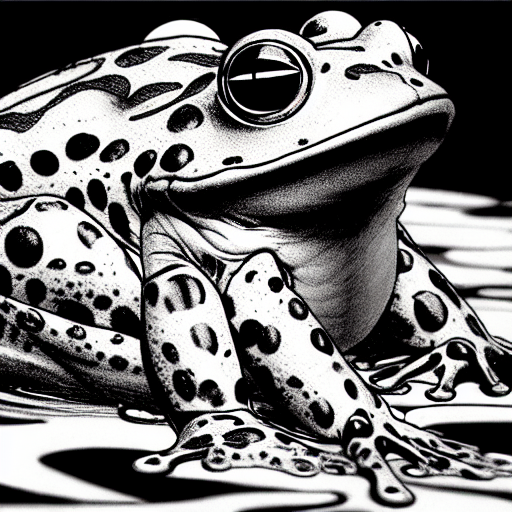

Init image used: /content/init_image/B.png
Generation processing: 2 / 2000
prompt: a scene of, a frog relaxing on a lilypad while ribbiting, black and white, comic book art, by yoji shinkawa an...


INFO:pytorch_lightning.utilities.seed:Global seed set to 134400935


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 36 timesteps


DDIM Sampler:  47%|████▋     | 17/36 [00:05<00:06,  2.92it/s]


KeyboardInterrupt: ignored

In [ ]:
#@title # Cell 3: Main Code (the magic button; **RUN IT!**)
##@markdown

import re
import random

# create a list of all the prompts from new line:
if type(promptsA) is str:
  promptsA = [i for i in promptsA.split('\n') if i]

# create a list of all the init images from new line:
if type(init_imgs_list) is str:
  init_imgs_list = [i for i in init_imgs_list.split('\n') if i]
if len(init_imgs_list) == 0:
  init_imgs_list.append("none")

def clean_string(s):
    s = ''.join([c for c in s if (re.match('[a-zA-Z0-9 _]', c) or ord(c) > 127)]).strip()
    if len(s) > 200:
        return (s[:150]).strip()
    return s

##1---------------------------------------------------------------------------------------------
#@markdown > <u>**Section 1): Saving/Folder Settings** *(required):* <br></u>
outputFolder = "testCode" #@param {type:"string"}
saveSeperatePromptsToSubfolders = False#@param{type:"boolean"}
# note: the actual saving to output directory was moved lower since we might want to save the prompt name there
#@markdown ---



##2---------------------------------------------------------------------------------------------
#@markdown > <u>**Section 2): Prompt Template** *(optional):*</u>
# <br>
#@markdown `Note: set to none if you rather type your prompt details in section 3) |  the selected template is used on EVERY prompt in the promptsA list`
promptTemplate = 'style - comic art inks' #@param ["none/custom","character - female adult", "character - male adult", "environment - scifi", "environment - fantasy", "vehicle - sketch", "vehicle - render", "style - anime keyframe (use high guidance scale of 15+)", "style - comic art inks", "style - blackwork / heavily inked tattoos", "fun - action figure character", "fun - stickers", "fun - marble statue"]
templateSelected = "none"
templateSelectedStart = ""
templateSelectedKey = 0

if promptTemplate == "none/custom":
  templateSelectedKey = 0
elif promptTemplate == "character - female adult":
  templateSelectedKey = 1
elif promptTemplate == "character - male adult":
  templateSelectedKey = 2
elif promptTemplate == "environment - scifi": 
  templateSelectedKey = 3
elif promptTemplate == "environment - fantasy": 
  templateSelectedKey = 4
elif promptTemplate == "vehicle - sketch": 
  templateSelectedKey = 5
elif promptTemplate == "vehicle - render": 
  templateSelectedKey = 6
elif promptTemplate == "style - anime keyframe (use high guidance scale of 15+)": 
  templateSelectedKey = 7
elif promptTemplate == "style - comic art inks": 
  templateSelectedKey = 8
elif promptTemplate == "style - blackwork / heavily inked tattoos": 
  templateSelectedKey = 9
elif promptTemplate == "fun - action figure character": 
  templateSelectedKey = 10
elif promptTemplate == "fun - stickers": 
  templateSelectedKey = 11
elif promptTemplate == "fun - marble statue": 
  templateSelectedKey = 12

# code for determining which key is selected:
# templateSelectedKey = 6
promptTemplatedSelectedlist = promptTemplateDict[int(templateSelectedKey)] # gets both the values of the selected key as a list, ex ['male', 'line art']
templateSelectedStart = promptTemplatedSelectedlist[0]
templateSelected = promptTemplatedSelectedlist[1]
# end template prompt list ------------------------------------------------------------

emotiveTemplate = 'none' #@param ["none", "happy", "angry", "sad", "zombie", "psychedelic", "sketchy drawing style"]
emoteTemplateSelected = "none"
if emotiveTemplate == "none":
  emoteTemplateSelected = "none"

elif emotiveTemplate == "happy":
  emoteTemplateSelected = "happy friendly cheerful smiling joy sparkling magical"

elif emotiveTemplate == "angry":
  emoteTemplateSelected = "villain angry pissed off frowning yelling spitting fighting violent extreme anger rage fury outrage furious open mouth"

elif emotiveTemplate == "sad":
  emoteTemplateSelected = "depressed sad saddened heartbroken pouting crying tears frown grief grieving hopeless whimpering"

elif emotiveTemplate == "zombie":
  emoteTemplateSelected = "black dark very dark black and creepy horror terrifying bloody gore wounds blood splats zombie terrified dead"

elif emotiveTemplate == "psychedelic":
  emoteTemplateSelected = "psychedelic trippy colorful neon kaleidoscope mushrooms trance bright mind-blowing mystical spiritual mysticism psilocybin hallucinogenic"

elif emotiveTemplate == "sketchy drawing style":
  emoteTemplateSelected = "line art line drawing pen and ink black and white simple simplified sketch drawing pencil drawing rough thin lines line linear etched flat drawing"

# end template emotive addition list -----------------------------------------------------------

randomEnd = "" #@param {type:"string"}
randomStringEnd = randomEnd.split(",")
numOfRandomStringEnd = len(randomStringEnd)
wordRNDMend = ""
#@markdown ---



##3---------------------------------------------------------------------------------------------
#@markdown > <u>**Section 3): Prompt Details** *(optional - toggle on/off):* <br></u>
# <br>
#@markdown `Note: these values are included on EVERY prompt in the list if no template is used and useThese3PromptFields = True`
useThese3PromptFields = False#@param{type:"boolean"}
randomStart = "intricate fine tipped pen drawing of a" #@param {type:"string"}
if useThese3PromptFields == False:
  randomStart = ""
wordRNDM = ""
randomStringLS = randomStart.split(",")
numOfRandomStringStart = len(randomStringLS)
midDetails = "" #@param {type:"string"}
endingStyle = "'inktober, Fine Line, manga line art, monochrome, dotwork, by dan hilliard, by Stanislaw Wilczynski, by alphonse mucha, by aaron horkey" #@param {type:"string"}
if useThese3PromptFields == False:
  midDetails = ""
  endingStyle = ""
# next we determine if we should actually use these custom strings or use our prompt templates:
promptsB = ""
if templateSelectedKey == 0:
  promptsB = [x + ", " + midDetails for x in promptsA] # add the universal style text to each prompt in the list
  prompts = [x + ", " + endingStyle for x in promptsB] # add the universal style text to each prompt in the list
else:
  prompts = [x + ", " + templateSelected for x in promptsA] # add the universal style text to each prompt in the list
#@markdown ---



##4---------------------------------------------------------------------------------------------
#@markdown > <u>**Section 4): Basic Settings** *(required - all modes):* </u><br>
#<br>
#@markdown `Note: Defaults: width/height = 640/640 | scale = 15 | steps = 50 | repeats = 6 | sampler = ddim | seed = -1 (random)`
width = 512 #@param {type:"integer"}
height = 512 #@param {type:"integer"}
aspectRatio = 'custom' #@param ["custom","1:1  (square)","4:3  (standard)","16:9 (widescreen)","21:9 (ultrawide)","4:5  (instagram)","8x11 (paper standard)","2:3  (poster standard)"]
if aspectRatio == "custom":
  width = width
  height = height
elif  aspectRatio == "1:1  (square)":
  width = 640
  height = 640
elif  aspectRatio == "4:3  (standard)":
  width = 768
  height = 576
elif  aspectRatio == "16:9 (widescreen)":
  width = 832
  height = 480
elif  aspectRatio == "21:9 (ultrawide)":
  width = 1024
  height = 448
elif  aspectRatio == "4:5  (instagram)":
  width = 512
  height = 640
elif  aspectRatio == "8x11 (paper standard)":
  width = 512
  height = 672
elif  aspectRatio == "2:3  (poster standard)":
  width = 512
  height = 768

width_height = [width, height] # param{type: 'raw'}
guidance_scale = 16 #@param {type:"slider", min:0, max:40, step:1}
steps = 35 #@param {type:"integer"}
samples_per_batch = 1 # not exposed, you can do 2 or more based on GPU ram, if get CUDA out of memory need to restart runtime
number_of_images = 1 #param {type:"integer"}
number_of_repeats = 2000 #@param {type:"integer"}
sampler = 'ddim' #@param ["klms","plms", "ddim"]
ddim_eta = 0.75 # param {type:"number"}
seed = -1 # @param {type:"integer"}
firstPromptOnly = True#@param{type:"boolean"}
#@markdown ---




##5---------------------------------------------------------------------------------------------
#@markdown > <u>**Section 5): Init Image (img2img)** *(optional):*</u><br> 
#<br>
#@markdown `Note: the default path is: / content/init_image/`
randomizeImageFromFolder = False#@param{type:"boolean"}
defaultInitPath = "/content/init_image/" #@param {type:"string"}
if defaultInitPath == "":
  defaultInitPath = "/content/init_image/"
  
initial_image = "" #@param {type:"string"}
checkForInitial_Image = len(initial_image)
if checkForInitial_Image == 0:
  init_image_or_folder = defaultInitPath
else:
  init_image_or_folder = defaultInitPath + initial_image
init_strength = -1 #@param {type:"number"}
#@markdown ---



##6---------------------------------------------------------------------------------------------
#@markdown > <u>**Section 6): Sequence Settings - Cycles** *(Through Ranges - optional):* <br></u>
#<br>
#@markdown `Note: use cycleThroughPromptList to create variations with the prompt templates`
# for template cycling, ex generating both male and female or sketch after the other:
cycleThroughPromptList = False#@param{type:"boolean"}
templatesToCycle = "1,2" #@param {type:"string"}
listOfTemplatesToCycle = templatesToCycle.split(",")
numOfTemplatesToCycle = len(listOfTemplatesToCycle)
# end template cycle variables-----
# these options would run 14 times:
init_strength_0_to_1 = False#@param{type:"boolean"}
cfg_scale_7_to_20 = False#@param{type:"boolean"}
init_strength_random = False#@param{type:"boolean"}
cfg_scale_random = False#@param{type:"boolean"}
#@markdown ---


##7---------------------------------------------------------------------------------------------
#@markdown > <u>**Section 7): Sequence Settings with Images** *(optional interpolation):* <br></u>
#<br>
# forgot what the next one does, it wasn't as good as doing the image cycle though:
useGeneratedImageAsInit = False#param{type:"boolean"}
# for interpolating using generated image cycles on INIT_STRENGTH:
generatedImageCycle = False#@param{type:"boolean"} 
specifyStrengthLock = 0.2 #@param {type:"number"} # -1 is default to go from 0.6 to 0.2; or you can lock to only gen say 0.05. It doesn't blend as well locking to a single value
activateStrengthLock = False
if specifyStrengthLock == -1:
  activateStrengthLock = False
else:
  activateStrengthLock = True
# prompts over time lets us pick keyframe for duration of certain prompts
usePromptsOverTimeCycle = False#@param{type:"boolean"}
# sometimes there's too large a jump when we go down to 0.2 inti strngth so this has smoother results:
promptOverTimeSetting03InsteadOf02 = False#@param{type:"boolean"}
promptsOverTimeFramesList = []
promptsOverTimePromptList = []
totalFrames = 0
# if we're using prompts over time, we take the user created DICT of frame count / prompts and split to new list
# based on frame count, we'll duplicate that prompt into the prompt list the rest of the script will read
if usePromptsOverTimeCycle == True:
  firstPromptOnly = False
  prompts.clear()
  promptsA.clear()
  promptsB = ""
  for key, values in promptInterpolateMulti.items():
     number = int(values[0]) # frame count
     promptsOverTimeFramesList.append(number) # add to list of frame counts, ex. 6
     promptsOverTimePromptList.append(values[1]) # adds to list of prompt strings, ex. 'cat'
  for x in promptsOverTimeFramesList:
    totalFrames += int(x) # this value will be the total of the prompts / frames we gen
  number_of_repeats = totalFrames # we might as well pick an accurate generation count to match our frame count. so override this user inputted variable
  counta = 0
  zz = 0
  for y in range(totalFrames):
    promptToSend = promptsOverTimePromptList[zz]
    promptsA.append(promptToSend)
    counta += 1
    if counta == (promptsOverTimeFramesList[zz]):
      zz += 1
      counta = 0
  if templateSelectedKey == 0:
    promptsB = [x + ", " + midDetails for x in promptsA] # add the universal style text to each prompt in the list
    prompts = [x + ", " + endingStyle for x in promptsB] # add the universal style text to each prompt in the list
  else:
    prompts = [x + ", " + templateSelected for x in promptsA] # add the universal style text to each prompt in the list
# ----- end set up of the usePromptsOverTimeCycle / multi prop with frame count cycle interpolation setup -----------------

save_settings_file = True#param{type:"boolean"} # it seems to break script if this is set to False, so I hid it

# Sequence Counter for evaluating cfg and init_strength scales:
areBothScalesToGen = False
if init_strength_0_to_1 == True:
  firstPromptOnly = True
  if cfg_scale_7_to_20 == True:
    number_of_repeats = 80 # value if both options are selected
    areBothScalesToGen = True
  else:
    number_of_repeats = 10
if cfg_scale_7_to_20 == True:
  firstPromptOnly = True
  if init_strength_0_to_1 == True:
    number_of_repeats = 80 # value if both options are selected
    areBothScalesToGen = True
  else:
    number_of_repeats = 8
counterCFG = 6
counterINITSTRENGTH = 0
counter = 0
countRepeats = -1
number_of_repeats_display = number_of_repeats
randomNumber = 0
countPromptTemplateCycles = -1
countSubfolderNumber = 0
sample_idx = 1 # reset this number every generation

# INIT_Image gen from drive:
activateUsePreviousGenImage = False # we have to activate this later in the code
areWeOnOddInitGenCycle = True # odd will gen random seed at 0.3, even will fen previous seed at 0.7
seedA_GenCycle = random.randint(0, 2**32) if seed == -1 else seed
seedB_GenCycle = random.randint(0, 2**32)
reset_init_strength_for_gen_cycle = False
if generatedImageCycle == True:
  init_strength = 0.9 #starting value for cycle; we go from 0.6 down to 0.2 in 0.1 increments
  init_strength_0_to_1 = False
  cfg_scale_7_to_20 = False

if firstPromptOnly == True:
  number_of_repeats_display = number_of_repeats
else:
  number_of_repeats_display = number_of_repeats * len(prompts)

# check if we're cycling through prompt templates:
if cycleThroughPromptList == True:
  if init_strength_0_to_1 == False and cfg_scale_7_to_20 == False:
    if usePromptsOverTimeCycle == False:
      number_of_repeats = numOfTemplatesToCycle * len(prompts)
      number_of_repeats_display = number_of_repeats
    elif usePromptsOverTimeCycle == True:
      number_of_repeats = numOfTemplatesToCycle
      number_of_repeats_display = number_of_repeats

if usePromptsOverTimeCycle == True:
  number_of_repeats_display = number_of_repeats
  number_of_repeats = 1 # we only repeat once since we already compiled all our prompts

# --------- CODE STARTS GENERATING ----------------
for x in range(number_of_repeats):
  countRepeats +=1
  countSubfolderNumber = 0
  # These counters count every time the prompt is sent for another repeat
  if firstPromptOnly == True:
    if init_strength_0_to_1 == False or cfg_scale_7_to_20 == False:
      counter = counter
  else:
    if init_strength_0_to_1 == False:
      counter = 0
    if cfg_scale_7_to_20 == False:
      counter = 0
  if init_strength_0_to_1 == True or cfg_scale_7_to_20 == True:
    if countRepeats == number_of_repeats:
      break

  # check if we're cycling through prompt templates and need to swap the prompt text:
  if cycleThroughPromptList == True:
    countPromptTemplateCycles += 1
    if templateSelectedKey == number_of_repeats: # prevents the list going out of range
      break
    try:
      templateSelectedKey = listOfTemplatesToCycle[countPromptTemplateCycles] # for some reason this line turns the into to string, so have to turn it back to int
    except:
      break
    promptTemplatedSelectedlist = promptTemplateDict[int(templateSelectedKey)] # gets both the values of the selected key as a list, ex ['male', 'line art']
    templateSelectedStart = promptTemplatedSelectedlist[0]
    templateSelected = promptTemplatedSelectedlist[1]
    prompts = [x + ", " + templateSelected for x in promptsA] # add the universal style text to each prompt in the list


  # calculating the full prompt: ----------------------------------
  for prompt in prompts:
    # check if we are only supposed to generate the first prompt or all them:
    if firstPromptOnly == True:
      if prompt == prompts[1]:
        break

    # the random start and end words are broken, for some reason
    if numOfRandomStringStart != 0 and numOfRandomStringStart != 1:
      # wordRNDM = random.choice(randomStringLS) # trash line didn't run properly
      number = ((seed - seed) + (numOfRandomStringStart - 1))
      randomNumber = random.randint(0, number)
      # print(numOfRandomStringStart)
      if randomNumber > numOfRandomStringStart or randomNumber <0:
        randomNumber = 0
      wordRNDM = randomStringLS[randomNumber]
    elif numOfRandomStringStart == 1:
      wordRNDM = randomStringLS[0]
    #print(randomNumber)
    #print(wordRNDM)

    if numOfRandomStringEnd != 0 and numOfRandomStringEnd != 1:
      # wordRNDMend = random.choice(randomStringEnd) # this trash didn't work for some reason
      number = ((seed - seed) + (numOfRandomStringEnd - 1))
      randomNumber = random.randint(0, number)
      if randomNumber > numOfRandomStringEnd or randomNumber <0:
        randomNumber = 0
      wordRNDMend = randomStringEnd[randomNumber]
    elif numOfRandomStringEnd == 1:
      wordRNDMend = randomStringEnd[0]

    if templateSelected != "none":
      randomStringLS = templateSelectedStart
      wordRNDM = templateSelectedStart

    # opt.prompt = prompt
    if numOfRandomStringStart == 0:
      if numOfRandomStringEnd == 0:
        promptPreFinal = prompt
      else:
        if len(wordRNDMend) == 0:
          promptPreFinal = prompt
        else:
          promptPreFinal = prompt + "," + wordRNDMend
    else:
      if numOfRandomStringEnd == 0:
        promptPreFinal = wordRNDM + ", " + prompt
      else:
        if len(wordRNDMend) == 0:
          promptPreFinal = wordRNDM + ", " + prompt
        else:
          promptPreFinal = wordRNDM + ", " + prompt + "," + wordRNDMend

    # finally bring the combined prompt together:
    if emoteTemplateSelected == "none":
      opt.prompt = promptPreFinal
    else:
      opt.prompt = promptPreFinal + " " + emoteTemplateSelected

    shortenedPromptNameList = prompt.split()[:3]
    shortenedPromptNameStr = " ".join(shortenedPromptNameList)
    batch_name = clean_string(shortenedPromptNameStr) # shorten the prompt word since the prompts are too long for windows!
    if generatedImageCycle == True:
      amountOfPaddingForN = len(str(number_of_repeats)) # how much padding to get
      xNum = f'{sample_idx:{0}{amountOfPaddingForN}}'
      paddedBatchName = str(xNum) + " " + batch_name
      batch_name = paddedBatchName

    # Related to INIT IMAGES:
    if init_imgs_list[0] != "none":
      # opt.outdir = os.path.join(outputs_path, batch_name) # if you want output dir to match the prompt
      if randomizeImageFromFolder == True and useGeneratedImageAsInit == False and generatedImageCycle == False:
        opt.init_img = init_image_or_folder
      if randomizeImageFromFolder == False and generatedImageCycle == False:
        if checkForInitial_Image == 0: # we have to check if user wants to run a single specific image (meaning the field in the init image area)
          if firstPromptOnly == False:
            full_init_img_path = init_image_or_folder + init_imgs_list[counter]
          else:
            full_init_img_path = init_image_or_folder + init_imgs_list[0]
        else:
          full_init_img_path = init_image_or_folder
        print("Init image used: " + full_init_img_path)
        opt.init_img = full_init_img_path


    opt.ddim_steps = steps
    opt.n_iter = 1
    opt.n_samples = samples_per_batch

    # seed creation and the cycle init image gen from itself:
    if generatedImageCycle == False:
      # pick random seed for images or the seed specified:
      opt.seed = random.randint(0, 2**32) if seed == -1 else seed
    else:
      # this only activates if we are trying to cycle through INIT image and reuse it from the generated location:
      # first gen only:
      if activateUsePreviousGenImage == False:
        opt.init_img = init_image_or_folder # do only on the first generation to get our input image
        activateUsePreviousGenImage = True

      # core cycle:
      init_strength_endPoint = 0.2 # how far we go from 0.6 to 0.2 or 0.3
      if promptOverTimeSetting03InsteadOf02 == True:
          init_strength_endPoint = 0.3 # for a more subtle interpolation
      if areWeOnOddInitGenCycle == True:
        opt.seed = seedA_GenCycle
        if activateStrengthLock == False:
          init_strength -= 0.1 # only go down 0.1 if there is no strength lock
          round(init_strength)
          if init_strength == init_strength_endPoint or init_strength <= (init_strength_endPoint + 0.1): # when we get to the end; either 0.2 or 0.3
            areWeOnOddInitGenCycle = False
            reset_init_strength_for_gen_cycle = True
            seedA_GenCycle +=1
        elif activateStrengthLock == True:
          areWeOnOddInitGenCycle = False
          init_strength = specifyStrengthLock
          reset_init_strength_for_gen_cycle = True
          seedA_GenCycle +=1

      elif areWeOnOddInitGenCycle == False:
        # opt.seed is previous result
        opt.seed = seedB_GenCycle
        if activateStrengthLock == False:
          init_strength -= 0.1
          round(init_strength)
          if init_strength == init_strength_endPoint or (init_strength_endPoint + 0.1):
            areWeOnOddInitGenCycle = True
            reset_init_strength_for_gen_cycle = True
            seedB_GenCycle +=1
        elif activateStrengthLock == True:
            areWeOnOddInitGenCycle = True
            init_strength = specifyStrengthLock
            reset_init_strength_for_gen_cycle = True
            seedB_GenCycle +=1     
          # ---------- END THE CYCLE THROUGH INIT --------------------------
      
    # choose to pull one of the generated images as INIT Image:
    if useGeneratedImageAsInit == True and generatedImageCycle == False:
      if activateUsePreviousGenImage == False:
        activateUsePreviousGenImage = True
      elif activateUsePreviousGenImage == True:
        # this will only run when activateUsePreviousGenImage = True as set above
        if generatedImageCycle == False:
          while not os.path.exists(lastGeneratedImagePath):
            time.sleep(1) 
          if os.path.isfile(lastGeneratedImagePath):
            opt.init_img = lastGeneratedImagePath
            seed += 1 # this technique only works if you use different seeds

    # CFG Calculation:    
    opt.sampler = sampler
    if cfg_scale_7_to_20 == False:
      opt.scale = guidance_scale
    else:
      opt.scale = counterCFG
    if cfg_scale_random == True:
      opt.scale = random.uniform(7, 20)

    # INIT IMAGE:
    if init_strength_0_to_1 == True:
      init_strength = counterINITSTRENGTH
    if init_strength_random == True:
      init_strength = random.uniform(0.1, 0.8)
    opt.strength = max(0.0, min(1.0, 1.0 - init_strength))

    #opt.W = width_height[0]
    #opt.H = width_height[1]
    opt.W, opt.H = map(lambda x: x - x % 64, (width_height[0], width_height[1])) # resize to integer multiple of 64

    # Counters:
    counter += 1 # I added this to keep track of INIT images
    if firstPromptOnly == True:
      if cycleThroughPromptList == True or usePromptsOverTimeCycle == True:
        print("Generations processed: " + str(counter) + " / " + str(numOfTemplatesToCycle))
      else: 
        print("Generation processing: " + str(counter) + " / " + str(number_of_repeats_display))    
    else:
        displayCounter = (len(prompts) * countRepeats) + counter
        if cycleThroughPromptList == True:
          print("Generations processed: " + str(counter) + " / " + str(numOfTemplatesToCycle * len(prompts)))
        else:        
          print("Generation processing: " + str(displayCounter) + " / " + str(number_of_repeats_display))
    if areBothScalesToGen == False:
      counterCFG += 2 # go up from 7 to 20 if activated
      counterINITSTRENGTH = counterINITSTRENGTH + 0.1 # go up from 0.1 to 0.8 if activated
    else:
      counterINITSTRENGTH = counterINITSTRENGTH + 0.1
      if counterINITSTRENGTH > 0.9:
        counterINITSTRENGTH = 0 # reset since we're now going to go to next CFG
        counterCFG += 2 # go up from 7 to 20 if activated

    if opt.strength >= 1 or init_image_or_folder == None or opt.strength <= 0:
        opt.init_img = ""

    if opt.init_img != None and opt.init_img != '':
        opt.sampler = 'ddim'

    if opt.sampler != 'ddim':
        opt.ddim_eta = 0.0

    # debugging during processing:
    print("prompt: " + opt.prompt[:110] +"...")

    # save settings
    settings = {
        'ddim_eta': ddim_eta,
        'guidance_scale': guidance_scale,
        'init_image': init_image_or_folder,
        'init_strength': init_strength,
        'number_of_images': number_of_images,
        'prompt': opt.prompt,
        'sampler': sampler,
        'samples_per_batch': samples_per_batch,
        'seed': opt.seed,
        'steps': steps,
        'width': opt.W,
        'height': opt.H,
    }
    # saving and making output directories:
    countSubfolderNumber += 1
    if saveSeperatePromptsToSubfolders == False:
      opt.outdir = os.path.join(outputs_path, outputFolder)
    else:
      numToUsePath = countSubfolderNumber.zfill(3)
      opt.outdir = os.path.join(outputs_path, outputFolder + "/" + str(numToUsePath) + " " + shortenedPromptNameStr)

    os.makedirs(opt.outdir, exist_ok=True)
    # filePathToSaveTo = opt.outdir + "/" + batch_name + "" + batch_idx.zfill(3)  + "_" + sample_idx.zfill(4) + " " + {opt.seed} + ".png"
    pathBatchIDPad = (f'{batch_idx:03}')
    pathsample_idx = (f'{sample_idx:04}') 
    lastGeneratedImagePath = opt.outdir + "/" + batch_name + "(" + str(pathBatchIDPad)  + ")_" + str(pathsample_idx) + " " + str(opt.seed) + ".png"

    # while os.path.isfile(f"{opt.outdir}/{batch_name}({batch_idx})_{sample_idx:04}_settings.txt"):
        #countSubfolderNumber += 1
        # print( "counting the prompt: " + str(countSubfolderNumber))
    if save_settings_file:
      with open(f"{opt.outdir}/{batch_name}({batch_idx})_{sample_idx:04}_settings.txt", "w+", encoding="utf-8") as f:
          json.dump(settings, f, ensure_ascii=False, indent=4)
    with open(f"{opt.outdir}/prompt.txt", 'w') as f:
          f.write(opt.prompt)
    # sample_idx = 0

    for i in range(number_of_images):
        gc.collect()
        torch.cuda.empty_cache()

        images = generate(opt)

        clear_output(wait=True)
        print(f"Used seed: {opt.seed}")
        if firstPromptOnly == True:
          if cycleThroughPromptList == True or usePromptsOverTimeCycle == True:
            print("Generations processed: " + str(counter) + " / " + str(numOfTemplatesToCycle))
          else:
            print("Generations processed: " + str(counter) + " / " + str(number_of_repeats_display))
        else:
          if cycleThroughPromptList == True:
            print("Generations processed: " + str(counter) + " / " + str(numOfTemplatesToCycle * len(prompts)))
          else:
            print("Generations processed: " + str(displayCounter) + " / " + str(number_of_repeats_display))
        # print(f"Saved to: {opt.outdir}")
        print("prompt: " + opt.prompt[:110] +"...")
        print(lastGeneratedImagePath)
        # print ("countdown of generatedImageCycle: " + str(init_strength))

        for image in images:
            display(image)

        batch_idx += 1
        sample_idx += 1
        # opt.seed += 1

    # change some settings like swap to previous generated image to cycle though generatedImageCycle:  
    if generatedImageCycle == True:
      if reset_init_strength_for_gen_cycle == True:
        reset_init_strength_for_gen_cycle = False
        init_strength = 0.7
        print("wait while loading... " + lastGeneratedImagePath)
        while not os.path.exists(lastGeneratedImagePath):
          time.sleep(1) 
        if os.path.isfile(lastGeneratedImagePath):
          opt.init_img = lastGeneratedImagePath


# 3. <u> Post Processing & Experimental Area </u> *(bonus / advanced)*
- do more with the generated results
- future: inpainting | facial recognition detailing | upscaling | video compiling

In [ ]:
# placeholder

In [ ]:
#@title Experimental Facial Recognition:
#@markdown `note: this script will go through the prompt list`<br>

##@markdown

import re
import random
# facial recognition code:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode
from PIL import Image, ImageDraw, ImageFilter
import os
import sys
import cv2

# create a list of all the prompts from new line:
if type(promptsA) is str:
  promptsA = [i for i in promptsA.split('\n') if i]

# create a list of all the init images from new line:
if type(init_imgs_list) is str:
  init_imgs_list = [i for i in init_imgs_list.split('\n') if i]

def clean_string(s):
    s = ''.join([c for c in s if (re.match('[a-zA-Z0-9 _]', c) or ord(c) > 127)]).strip()
    if len(s) > 200:
        return (s[:150]).strip()
    return s

##@markdown Shared Prompt Ending:
outputFolder = "testFacialRecognition_upres" #@param {type:"string"}
init_image_or_folderPath = "/content/init_image/"
saveSeperatePromptsToSubfolders = False#@param{type:"boolean"}
imgPathOutput = "/content/known/study.jpg"
# note: the actual saving to output directory was moved lower since we might want to save the prompt name there

#@markdown Prompt Template (set to none if you rather type your prompt details):
promptTemplate = 'none/custom' #@param ["none/custom","character - female adult", "character - male adult", "environment - scifi", "environment - fantasy", "vehicle - sketch", "vehicle - render", "style - anime keyframe (use high guidance scale of 15+)", "style - comic art inks", "style - blackwork / heavily inked tattoos", "fun - action figure character", "fun - stickers", "fun - marble statue"]
templateSelected = "none"
templateSelectedStart = ""
templateSelectedKey = 0

if promptTemplate == "none/custom":
  templateSelectedKey = 0
elif promptTemplate == "character - female adult":
  templateSelectedKey = 1
elif promptTemplate == "character - male adult":
  templateSelectedKey = 2
elif promptTemplate == "environment - scifi": 
  templateSelectedKey = 3
elif promptTemplate == "environment - fantasy": 
  templateSelectedKey = 4
elif promptTemplate == "vehicle - sketch": 
  templateSelectedKey = 5
elif promptTemplate == "vehicle - render": 
  templateSelectedKey = 6
elif promptTemplate == "style - anime keyframe (use high guidance scale of 15+)": 
  templateSelectedKey = 7
elif promptTemplate == "style - comic art inks": 
  templateSelectedKey = 8
elif promptTemplate == "style - blackwork / heavily inked tattoos": 
  templateSelectedKey = 9
elif promptTemplate == "fun - action figure character": 
  templateSelectedKey = 10
elif promptTemplate == "fun - stickers": 
  templateSelectedKey = 11
elif promptTemplate == "fun - marble statue": 
  templateSelectedKey = 12

# code for determining which key is selected:
# templateSelectedKey = 6
promptTemplatedSelectedlist = promptTemplateDict[int(templateSelectedKey)] # gets both the values of the selected key as a list, ex ['male', 'line art']
templateSelectedStart = promptTemplatedSelectedlist[0]
templateSelected = promptTemplatedSelectedlist[1]
# end template prompt list ------------------------------------------------------------

emotiveTemplate = 'none' #@param ["none", "happy", "angry", "sad", "zombie", "psychedelic", "sketchy drawing style"]
emoteTemplateSelected = "none"
if emotiveTemplate == "none":
  emoteTemplateSelected = "none"

elif emotiveTemplate == "happy":
  emoteTemplateSelected = "happy friendly cheerful smiling joy sparkling magical"

elif emotiveTemplate == "angry":
  emoteTemplateSelected = "villain angry pissed off frowning yelling spitting fighting violent extreme anger rage fury outrage furious open mouth"

elif emotiveTemplate == "sad":
  emoteTemplateSelected = "depressed sad saddened heartbroken pouting crying tears frown grief grieving hopeless whimpering"

elif emotiveTemplate == "zombie":
  emoteTemplateSelected = "black dark very dark black and creepy horror terrifying bloody gore wounds blood splats zombie terrified dead"

elif emotiveTemplate == "psychedelic":
  emoteTemplateSelected = "psychedelic trippy colorful neon kaleidoscope mushrooms trance bright mind-blowing mystical spiritual mysticism psilocybin hallucinogenic"

elif emotiveTemplate == "sketchy drawing style":
  emoteTemplateSelected = "line art line drawing pen and ink black and white simple simplified sketch drawing pencil drawing rough thin lines line linear etched flat drawing"

# end template emotive addition list -----------------------------------------------------------

randomEnd = "" #@param {type:"string"}
randomStringEnd = randomEnd.split(",")
numOfRandomStringEnd = len(randomStringEnd)
wordRNDMend = ""

# custom prompt settings if 'none' template selected:
#@markdown Prompt Details (these values are included on EVERY prompt in the list if no template is used):
randomStart = "female" #@param {type:"string"}
wordRNDM = ""
randomStringLS = randomStart.split(",")
numOfRandomStringStart = len(randomStringLS)
midDetails = "portrait, young woman, detailed gorgeous face, digital art, painting, artstation, concept art, smooth, sharp focus, high definition, detailed" #@param {type:"string"}
endingStyle = "illustration, art by artgerm and greg rutkowski and alphonse mucha" #@param {type:"string"}
# next we determine if we should actually use these custom strings or use our prompt templates:
promptsB = ""
if templateSelectedKey == 0:
  promptsB = [x + ", " + midDetails for x in promptsA] # add the universal style text to each prompt in the list
  prompts = [x + ", " + endingStyle for x in promptsB] # add the universal style text to each prompt in the list
else:
  prompts = [x + ", " + templateSelected for x in promptsA] # add the universal style text to each prompt in the list

#@markdown Basic Settings:
width = 700 #@param {type:"integer"}
height = 700 #@param {type:"integer"}
width_height = [width, height] # param{type: 'raw'}
guidance_scale = 16 #@param {type:"slider", min:0, max:40, step:1}
steps = 30 #@param {type:"integer"}
samples_per_batch = 1 # not exposed, you can do 2 or more based on GPU ram, if get CUDA out of memory need to restart runtime
number_of_images = 1 #param {type:"integer"}
number_of_repeats = 2 #@param {type:"integer"}
sampler = 'ddim' #@param ["klms","plms", "ddim"]
ddim_eta = 0.75 # param {type:"number"}
useFacialRecognitionUpres = False#@param{type:"boolean"}

#@markdown Init image
randomizeImageFromFolder = False#@param{type:"boolean"}
initial_image = "" #@param {type:"string"}
checkForInitial_Image = len(initial_image)
if checkForInitial_Image == 0:
  init_image_or_folder = init_image_or_folderPath
else:
  init_image_or_folder = init_image_or_folderPath + initial_image
init_strength = 0.2 #@param {type:"number"}

#@markdown Sequence Settings
seed = -1 # @param {type:"integer"}
firstPromptOnly = False#@param{type:"boolean"}
#@markdown `Note: Can iterate on a seed through the scales to see how the values affects results, or randomize:`
# these options would run 14 times:
init_strength_0_to_1 = False#@param{type:"boolean"}
cfg_scale_7_to_20 = False#@param{type:"boolean"}
cycleThroughPromptList = False#@param{type:"boolean"}
# for template cycling, ex generating both male and female or sketch after the other:
templatesToCycle = "1,2" #@param {type:"string"}
listOfTemplatesToCycle = templatesToCycle.split(",")
numOfTemplatesToCycle = len(listOfTemplatesToCycle)
# end template cycle variables-----
init_strength_random = False#@param{type:"boolean"}
cfg_scale_random = False#@param{type:"boolean"}
#@markdown Sequence Settings with Images:
useGeneratedImageAsInit = False#@param{type:"boolean"}
generatedImageCycle = False#@param{type:"boolean"}
specifyStrengthLock = -1 #@param {type:"number"}
activateStrengthLock = False
if specifyStrengthLock == -1:
  activateStrengthLock = False
else:
  activateStrengthLock = True

save_settings_file = True#param{type:"boolean"} # it seems to break script if this is set to False, so I hid it


# Sequence Counter for evaluating cfg and init_strength scales:
areBothScalesToGen = False
if init_strength_0_to_1 == True:
  firstPromptOnly = True
  if cfg_scale_7_to_20 == True:
    number_of_repeats = 80 # value if both options are selected
    areBothScalesToGen = True
  else:
    number_of_repeats = 10
if cfg_scale_7_to_20 == True:
  firstPromptOnly = True
  if init_strength_0_to_1 == True:
    number_of_repeats = 80 # value if both options are selected
    areBothScalesToGen = True
  else:
    number_of_repeats = 8
counterCFG = 6
counterINITSTRENGTH = 0
counter = 0
countRepeats = -1
number_of_repeats_display = number_of_repeats
randomNumber = 0
countPromptTemplateCycles = -1
countSubfolderNumber = 0
sample_idx = 1 # reset this number every generation

# INIT_Image gen from drive:
activateUsePreviousGenImage = False # we have to activate this later in the code
areWeOnOddInitGenCycle = True # odd will gen random seed at 0.3, even will fen previous seed at 0.7
seedA_GenCycle = random.randint(0, 2**32) if seed == -1 else seed
seedB_GenCycle = random.randint(0, 2**32)
reset_init_strength_for_gen_cycle = False
if generatedImageCycle == True:
  init_strength = 0.9 #starting value for cycle; we go from 0.6 down to 0.2 in 0.1 increments
  init_strength_0_to_1 = False
  cfg_scale_7_to_20 = False

if firstPromptOnly == True:
  number_of_repeats_display = number_of_repeats
else:
  number_of_repeats_display = number_of_repeats * len(prompts)

# check if we're cycling through prompt templates:
if cycleThroughPromptList == True:
  if init_strength_0_to_1 == False and cfg_scale_7_to_20 == False:
    number_of_repeats = numOfTemplatesToCycle * len(prompts)
    number_of_repeats_display = number_of_repeats

# --------- CODE STARTS GENERATING ----------------
for x in range(number_of_repeats):
  countRepeats +=1
  countSubfolderNumber = 0
  # These counters count every time the prompt is sent for another repeat
  if firstPromptOnly == True:
    if init_strength_0_to_1 == False or cfg_scale_7_to_20 == False:
      counter = counter
  else:
    if init_strength_0_to_1 == False:
      counter = 0
    if cfg_scale_7_to_20 == False:
      counter = 0
  if init_strength_0_to_1 == True or cfg_scale_7_to_20 == True:
    if countRepeats == number_of_repeats:
      break

  # check if we're cycling through prompt templates and need to swap the prompt text:
  if cycleThroughPromptList == True:
    countPromptTemplateCycles += 1
    if templateSelectedKey == number_of_repeats: # prevents the list going out of range
      break
    try:
      templateSelectedKey = listOfTemplatesToCycle[countPromptTemplateCycles] # for some reason this line turns the into to string, so have to turn it back to int
    except:
      break
    promptTemplatedSelectedlist = promptTemplateDict[int(templateSelectedKey)] # gets both the values of the selected key as a list, ex ['male', 'line art']
    templateSelectedStart = promptTemplatedSelectedlist[0]
    templateSelected = promptTemplatedSelectedlist[1]
    prompts = [x + ", " + templateSelected for x in promptsA] # add the universal style text to each prompt in the list


  # calculating the full prompt: ----------------------------------
  for prompt in prompts:
    # check if we are only supposed to generate the first prompt or all them:
    if firstPromptOnly == True:
      if prompt == prompts[1]:
        break

    # the random start and end words are broken, for some reason
    if numOfRandomStringStart != 0 and numOfRandomStringStart != 1:
      # wordRNDM = random.choice(randomStringLS) # trash line didn't run properly
      number = ((seed - seed) + (numOfRandomStringStart - 1))
      randomNumber = random.randint(0, number)
      # print(numOfRandomStringStart)
      if randomNumber > numOfRandomStringStart or randomNumber <0:
        randomNumber = 0
      wordRNDM = randomStringLS[randomNumber]
    elif numOfRandomStringStart == 1:
      wordRNDM = randomStringLS[0]
    #print(randomNumber)
    #print(wordRNDM)

    if numOfRandomStringEnd != 0 and numOfRandomStringEnd != 1:
      # wordRNDMend = random.choice(randomStringEnd) # this trash didn't work for some reason
      number = ((seed - seed) + (numOfRandomStringEnd - 1))
      randomNumber = random.randint(0, number)
      if randomNumber > numOfRandomStringEnd or randomNumber <0:
        randomNumber = 0
      wordRNDMend = randomStringEnd[randomNumber]
    elif numOfRandomStringEnd == 1:
      wordRNDMend = randomStringEnd[0]

    if templateSelected != "none":
      randomStringLS = templateSelectedStart
      wordRNDM = templateSelectedStart

    # opt.prompt = prompt
    if numOfRandomStringStart == 0:
      if numOfRandomStringEnd == 0:
        promptPreFinal = prompt
      else:
        if len(wordRNDMend) == 0:
          promptPreFinal = prompt
        else:
          promptPreFinal = prompt + "," + wordRNDMend
    else:
      if numOfRandomStringEnd == 0:
        promptPreFinal = wordRNDM + ", " + prompt
      else:
        if len(wordRNDMend) == 0:
          promptPreFinal = wordRNDM + ", " + prompt
        else:
          promptPreFinal = wordRNDM + ", " + prompt + "," + wordRNDMend

    # finally bring the combined prompt together:
    if emoteTemplateSelected == "none":
      opt.prompt = promptPreFinal
    else:
      opt.prompt = promptPreFinal + " " + emoteTemplateSelected

    shortenedPromptNameList = prompt.split()[:3]
    shortenedPromptNameStr = " ".join(shortenedPromptNameList)
    batch_name = clean_string(shortenedPromptNameStr) # shorten the prompt word since the prompts are too long for windows!
    if generatedImageCycle == True:
      amountOfPaddingForN = len(str(number_of_repeats)) # how much padding to get
      xNum = f'{sample_idx:{0}{amountOfPaddingForN}}'
      paddedBatchName = str(xNum) + " " + batch_name
      batch_name = paddedBatchName

    # Related to INIT IMAGES:
    # opt.outdir = os.path.join(outputs_path, batch_name) # if you want output dir to match the prompt
    if randomizeImageFromFolder == True and useGeneratedImageAsInit == False and generatedImageCycle == False:
      opt.init_img = init_image_or_folder
    if randomizeImageFromFolder == False and generatedImageCycle == False:
      if checkForInitial_Image == 0: # we have to check if user wants to run a single specific image (meaning the field in the init image area)
        if firstPromptOnly == False:
          full_init_img_path = init_image_or_folder + init_imgs_list[counter]
        else:
          full_init_img_path = init_image_or_folder + init_imgs_list[0]
      else:
        full_init_img_path = init_image_or_folder
      print("Init image used: " + full_init_img_path)
      opt.init_img = full_init_img_path
    opt.ddim_steps = steps
    opt.n_iter = 1
    opt.n_samples = samples_per_batch

    # seed creation and the cycle init image gen from itself:
    if generatedImageCycle == False:
      # pick random seed for images or the seed specified:
      opt.seed = random.randint(0, 2**32) if seed == -1 else seed
    else:
      # this only activates if we are trying to cycle through INIT image and reuse it from the generated location:
      # first gen only:
      if activateUsePreviousGenImage == False:
        opt.init_img = init_image_or_folder # do only on the first generation to get our input image
        activateUsePreviousGenImage = True

      # core cycle:  
      if areWeOnOddInitGenCycle == True:
        opt.seed = seedA_GenCycle
        if activateStrengthLock == False:
          init_strength -= 0.1 # only go down 0.1 if there is no strength lock
          round(init_strength)
          if init_strength == 0.2 or init_strength <= 0.3:
            areWeOnOddInitGenCycle = False
            reset_init_strength_for_gen_cycle = True
            seedA_GenCycle +=1
        elif activateStrengthLock == True:
          areWeOnOddInitGenCycle = False
          init_strength = specifyStrengthLock
          reset_init_strength_for_gen_cycle = True
          seedA_GenCycle +=1

      elif areWeOnOddInitGenCycle == False:
        # opt.seed is previous result
        opt.seed = seedB_GenCycle
        if activateStrengthLock == False:
          init_strength -= 0.1
          round(init_strength)
          if init_strength == 0.2 or init_strength <= 0.3:
            areWeOnOddInitGenCycle = True
            reset_init_strength_for_gen_cycle = True
            seedB_GenCycle +=1
        elif activateStrengthLock == True:
            areWeOnOddInitGenCycle = True
            init_strength = specifyStrengthLock
            reset_init_strength_for_gen_cycle = True
            seedB_GenCycle +=1     
          # ---------- END THE CYCLE THROUGH INIT --------------------------
      
    # choose to pull one of the generated images as INIT Image:
    if useGeneratedImageAsInit == True and generatedImageCycle == False:
      if activateUsePreviousGenImage == False:
        activateUsePreviousGenImage = True
      elif activateUsePreviousGenImage == True:
        # this will only run when activateUsePreviousGenImage = True as set above
        if generatedImageCycle == False:
          while not os.path.exists(lastGeneratedImagePath):
            time.sleep(1) 
          if os.path.isfile(lastGeneratedImagePath):
            opt.init_img = lastGeneratedImagePath
            seed += 1 # this technique only works if you use different seeds

    # CFG Calculation:    
    opt.sampler = sampler
    if cfg_scale_7_to_20 == False:
      opt.scale = guidance_scale
    else:
      opt.scale = counterCFG
    if cfg_scale_random == True:
      opt.scale = random.uniform(7, 20)

    # INIT IMAGE:
    if init_strength_0_to_1 == True:
      init_strength = counterINITSTRENGTH
    if init_strength_random == True:
      init_strength = random.uniform(0.1, 0.8)
    opt.strength = max(0.0, min(1.0, 1.0 - init_strength))

    #opt.W = width_height[0]
    #opt.H = width_height[1]
    opt.W, opt.H = map(lambda x: x - x % 64, (width_height[0], width_height[1])) # resize to integer multiple of 64

    # Counters:
    counter += 1 # I added this to keep track of INIT images
    if firstPromptOnly == True:
      if cycleThroughPromptList == True:
        print("Generations processed: " + str(counter) + " / " + str(numOfTemplatesToCycle))
      else: 
        print("Generation processing: " + str(counter) + " / " + str(number_of_repeats_display))    
    else:
        displayCounter = (len(prompts) * countRepeats) + counter
        if cycleThroughPromptList == True:
          print("Generations processed: " + str(counter) + " / " + str(numOfTemplatesToCycle * len(prompts)))
        else:        
          print("Generation processing: " + str(displayCounter) + " / " + str(number_of_repeats_display))
    if areBothScalesToGen == False:
      counterCFG += 2 # go up from 7 to 20 if activated
      counterINITSTRENGTH = counterINITSTRENGTH + 0.1 # go up from 0.1 to 0.8 if activated
    else:
      counterINITSTRENGTH = counterINITSTRENGTH + 0.1
      if counterINITSTRENGTH > 0.9:
        counterINITSTRENGTH = 0 # reset since we're now going to go to next CFG
        counterCFG += 2 # go up from 7 to 20 if activated

    if opt.strength >= 1 or init_image_or_folder == None:
        opt.init_img = ""

    if opt.init_img != None and opt.init_img != '':
        opt.sampler = 'ddim'

    if opt.sampler != 'ddim':
        opt.ddim_eta = 0.0

    # debugging during processing:
    print("prompt: " + opt.prompt[:110] +"...")

    # save settings
    settings = {
        'ddim_eta': ddim_eta,
        'guidance_scale': guidance_scale,
        'init_image': init_image_or_folder,
        'init_strength': init_strength,
        'number_of_images': number_of_images,
        'prompt': opt.prompt,
        'sampler': sampler,
        'samples_per_batch': samples_per_batch,
        'seed': opt.seed,
        'steps': steps,
        'width': opt.W,
        'height': opt.H,
    }
    # saving and making output directories:
    countSubfolderNumber += 1
    if saveSeperatePromptsToSubfolders == False:
      opt.outdir = os.path.join(outputs_path, outputFolder)
    else:
      numToUsePath = countSubfolderNumber.zfill(3)
      opt.outdir = os.path.join(outputs_path, outputFolder + "/" + str(numToUsePath) + " " + shortenedPromptNameStr)

    os.makedirs(opt.outdir, exist_ok=True)
    # filePathToSaveTo = opt.outdir + "/" + batch_name + "" + batch_idx.zfill(3)  + "_" + sample_idx.zfill(4) + " " + {opt.seed} + ".png"
    pathBatchIDPad = (f'{batch_idx:03}')
    pathsample_idx = (f'{sample_idx:04}') 
    lastGeneratedImagePath = opt.outdir + "/" + batch_name + "(" + str(pathBatchIDPad)  + ")_" + str(pathsample_idx) + " " + str(opt.seed) + ".png"

    # while os.path.isfile(f"{opt.outdir}/{batch_name}({batch_idx})_{sample_idx:04}_settings.txt"):
        #countSubfolderNumber += 1
        # print( "counting the prompt: " + str(countSubfolderNumber))
    if save_settings_file:
      with open(f"{opt.outdir}/{batch_name}({batch_idx})_{sample_idx:04}_settings.txt", "w+", encoding="utf-8") as f:
          json.dump(settings, f, ensure_ascii=False, indent=4)
    with open(f"{opt.outdir}/prompt.txt", 'w') as f:
          f.write(opt.prompt)
    # sample_idx = 0

    for i in range(number_of_images):
        gc.collect()
        torch.cuda.empty_cache()

        images = generate(opt)

        clear_output(wait=True)
        print(f"Used seed: {opt.seed}")
        if firstPromptOnly == True:
          if cycleThroughPromptList == True:
            print("Generations processed: " + str(counter) + " / " + str(numOfTemplatesToCycle))
          else:
            print("Generations processed: " + str(counter) + " / " + str(number_of_repeats_display))
        else:
          if cycleThroughPromptList == True:
            print("Generations processed: " + str(counter) + " / " + str(numOfTemplatesToCycle * len(prompts)))
          else:
            print("Generations processed: " + str(displayCounter) + " / " + str(number_of_repeats_display))
        # print(f"Saved to: {opt.outdir}")
        print("prompt: " + opt.prompt[:110] +"...")
        print(lastGeneratedImagePath)
        # print ("countdown of generatedImageCycle: " + str(init_strength))

        # -------------------------------------------------------------------------------
        # -------------------------FACIAL RECOGNITION: ----------------------------------
        if useFacialRecognitionUpres == True or useFacialRecognitionUpres == False:
          # A) Check the Image for Faces and crop it: -------------------------------------------
          while not os.path.exists(lastGeneratedImagePath):
            time.sleep(1) 
          
          imgPathInput = lastGeneratedImagePath
          imgPathOutput = "/content/facialRecognition/facial_recognition_reference.jpg"
          # we need to save the x and y coordinates of the face image so we can swap it out later:
          # we also need to save the length and width:

          positionFaceImageX = 0
          positionFaceImageY = 0
          positionFaceImageW = 0
          positionFaceImageH = 0

          # 1) read the image from path:
          img = cv2.imread(imgPathInput)

          # 2) convert image to grayscale (required by image recognition model):
          gray_img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

          # 3) Use the Haar Cascade model to detect faces from the image:
          face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
          eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')
          faces = face_cascade.detectMultiScale(gray_img,1.1,4)

          # 4) print the number of faces detected:
          #print(f"len(faces)} faces detected in the image.")

          # 5a) Draw rectangle around the faces and crop the faces:
          # 5b) also save the correct position data (the distance of top left corner + crop W & H):
          for f in faces:
            x1, y1, w1, h1 = [ v for v in f ]
            calculateDistancePixelsPercentage = int(y1 / 2.5)
            calculateDistancePixels = int(y1 - calculateDistancePixelsPercentage)
            positionFaceImageX = x = int(x1 - calculateDistancePixels)
            positionFaceImageY = y = int(y1 - calculateDistancePixels)
            positionFaceImageW = w = int(w1 + (calculateDistancePixels * 2))
            positionFaceImageH = h = int(h1 + (calculateDistancePixels * 2))

            sub_face = img[y:y+h, x:x+w]
            fname, ext = os.path.splitext(imgPathInput)
            pathToSaveCrop = opt.outdir + "/crops/" + batch_name + "(" + str(pathBatchIDPad)  + ")_" + str(pathsample_idx) + " " + str(opt.seed) + ".png"
            # cv2.rectangle(img, (x,y), (x+w,y+h), (256,256,256), thickness=20) # FOR DEBUGGING IF THE IMAGE IS BEING PLACED CORRECTLY BACK ON THE FULL IMG
            #cv2.imwrite(pathToSaveCrop, sub_face)
            #cv2.imwrite(fname+"_cropped_"+ext, sub_face)
            cv2.imwrite(fname+"_cropped_"  + str(batch_idx) +ext, sub_face)
            cv2.rectangle(img, (x,y), (x+w,y+h), (256,256,256), thickness=2)
            cv2.rectangle(img, (x1, y1), (x1 + w1, y1+h1), color=(0, 256, 0), thickness=1) 
            break # only process the first face result, if there are multiple faces those get skipped
          # save the image with rectangles
          cv2.imwrite(imgPathOutput, img)
          
        # ----------------------END FACIAL RECOGNITION P1 -------------------------------
        # -------------------------------------------------------------------------------

        for image in images:
            display(image)

        batch_idx += 1
        sample_idx += 1
        # opt.seed += 1

        # change some settings like swap to previous generated image to cycle though generatedImageCycle:  
        if generatedImageCycle == True:
          if reset_init_strength_for_gen_cycle == True:
            reset_init_strength_for_gen_cycle = False
            init_strength = 0.7
            print("wait while loading... " + lastGeneratedImagePath)
            while not os.path.exists(lastGeneratedImagePath):
              time.sleep(1) 
            if os.path.isfile(lastGeneratedImagePath):
              opt.init_img = lastGeneratedImagePath
      
